In [1]:
import os
import sys

import glob

import random

import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

import numpy as np

import logging

import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    AsChannelFirst,
    EnsureChannelFirst,
    Compose,
    Resize,
)

import itk

import site
site.addsitedir("../ARGUS")

from ARGUS_Transforms import ARGUS_RandSpatialCropSlices

from itkwidgets import view

In [2]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images_ptx = glob.glob("Data_TaskId/PTX*.mha")
labels_ptx = np.zeros(len(images_ptx)).astype(int)
images_pnb = glob.glob("Data_TaskId/PNB*.mha")
labels_pnb = np.ones(len(images_pnb)).astype(int)
images_ons = glob.glob("Data_TaskId/ONS*.mha")
labels_ons = np.ones(len(images_ons)).astype(int)*2
images_ett = glob.glob("Data_TaskId/ETT*.mha")
labels_ett = np.ones(len(images_ett)).astype(int)*3

images = np.concatenate((images_ptx, images_pnb, images_ons, images_ett), axis=None)
labels = np.concatenate((labels_ptx, labels_pnb, labels_ons, labels_ett), axis=None)

# Shuffle two lists with same order
# Using zip() + * operator + shuffle()
temp = list(zip(images, labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
images, labels = list(res1), list(res2)

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels_onehot = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [20]:
# Define transforms
train_transforms = Compose([AsChannelFirst(),
                            ARGUS_RandSpatialCropSlices(
                                num_slices=1,
                                axis=0,
                                reduce_to_statistics=False,
                                extended=False,
                                include_center_slice=False,
                                include_gradient=False,
                            ),
                           ])

val_transforms = Compose([AsChannelFirst(),
                            ARGUS_RandSpatialCropSlices(
                                num_slices=1,
                                axis=0,
                                reduce_to_statistics=False,
                                extended=False,
                                include_center_slice=False,
                                include_gradient=False,
                            ),
                           ])

<class 'monai.data.meta_tensor.MetaTensor'> (1, 1, 256, 256) tensor([3]) torch.Size([1])



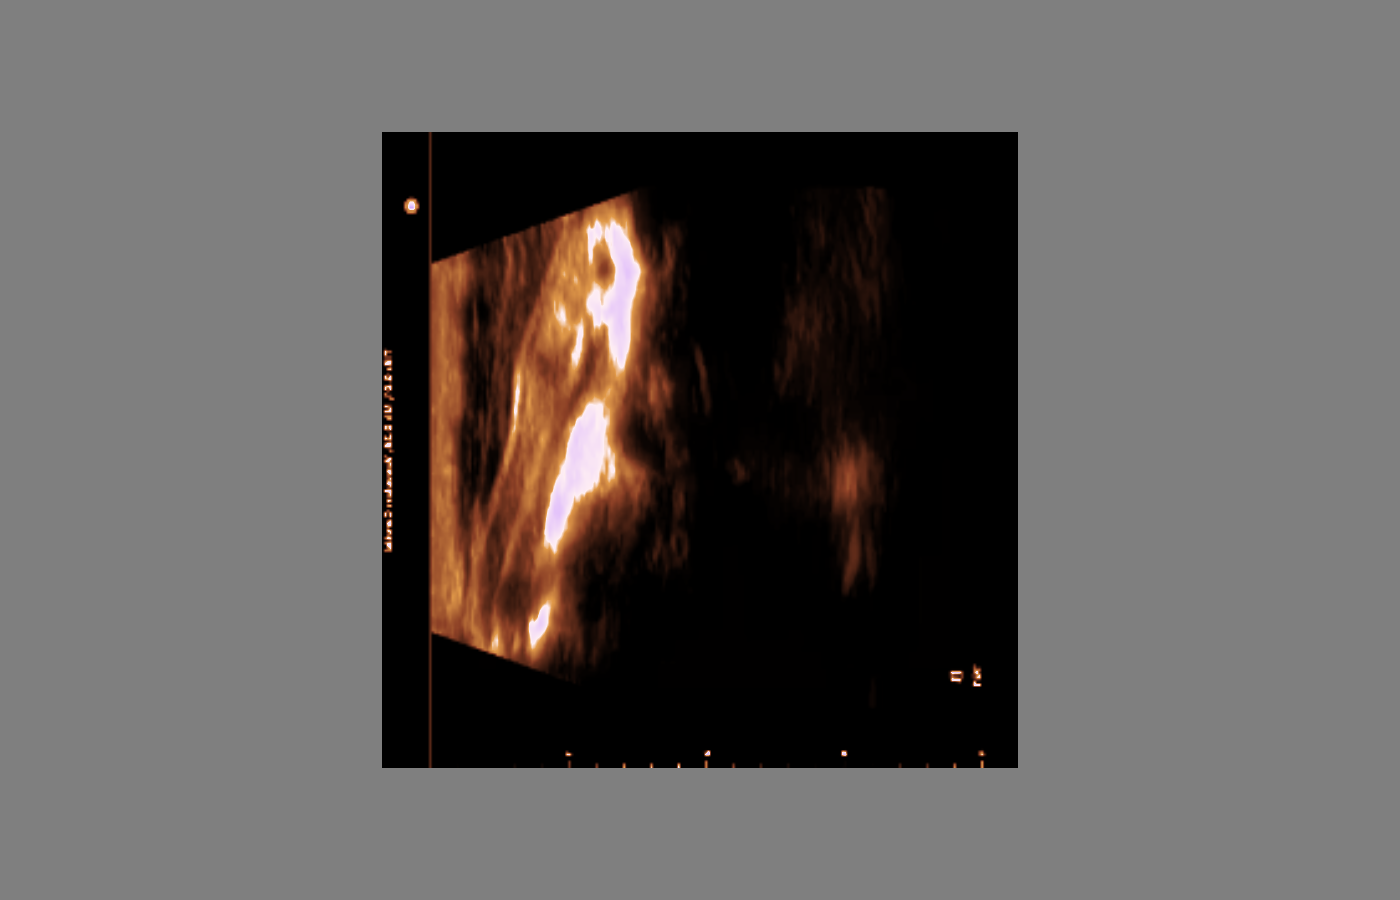
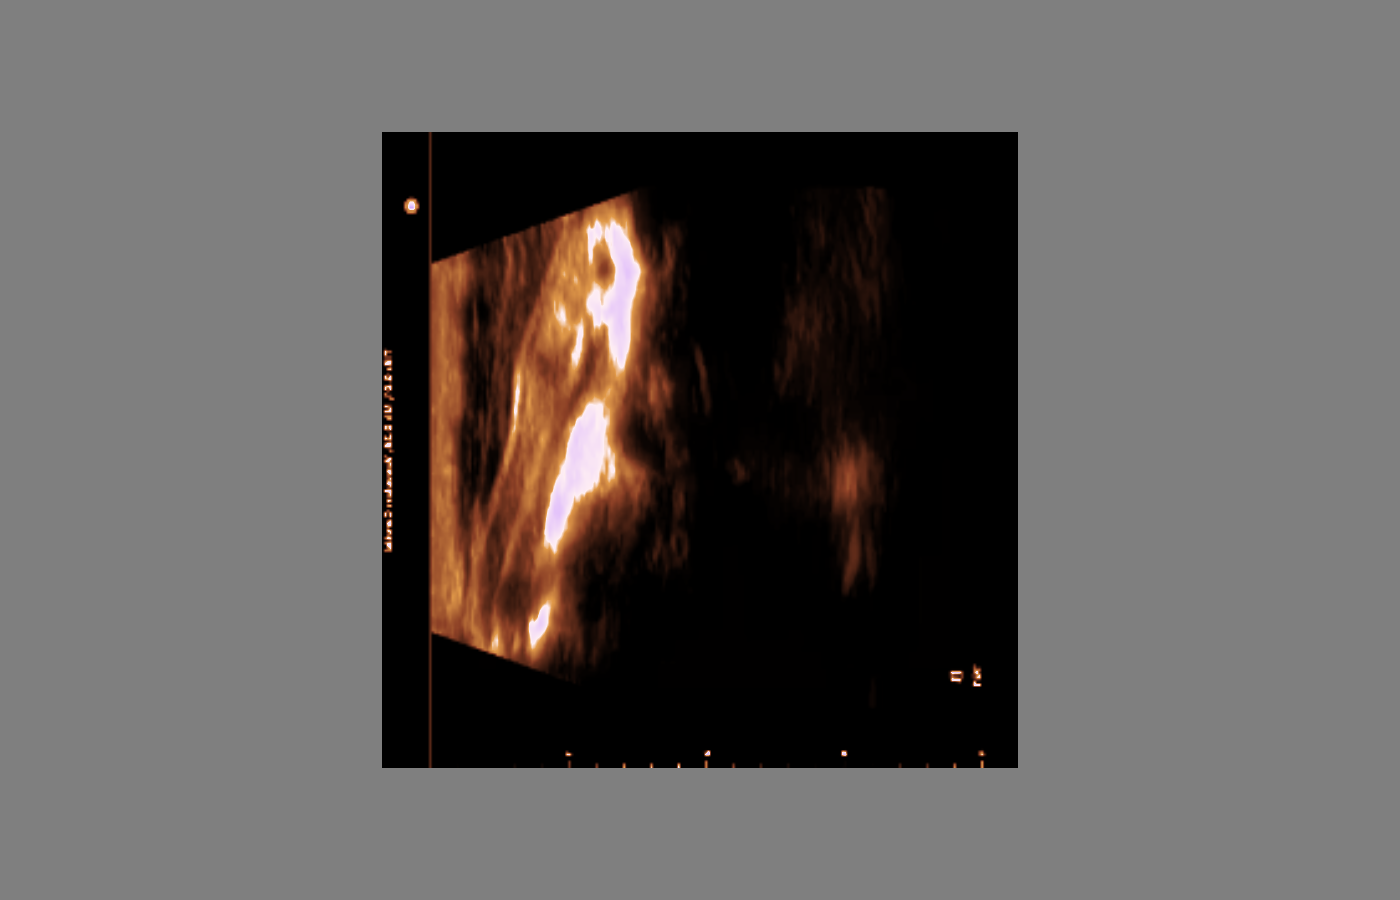

<IPython.core.display.Javascript object>

In [21]:
# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=1, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)
view(im[0,0])

In [6]:
# create a training data loader
train_ds = ImageDataset(image_files=images[:-10], labels=labels[:-10], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

In [8]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=4).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                print(val_outputs.shape, val_labels.shape)
                print(val_outputs.argmax(dim=1))
                print(val_labels)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "Results/best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/5
1/15, train_loss: 1.4107
2/15, train_loss: 1.3259
3/15, train_loss: 1.1471
4/15, train_loss: 1.1559
5/15, train_loss: 0.9743
6/15, train_loss: 0.8942
7/15, train_loss: 0.7789
8/15, train_loss: 0.7491
9/15, train_loss: 0.7026
10/15, train_loss: 0.6136
11/15, train_loss: 0.5742
12/15, train_loss: 0.4972
13/15, train_loss: 0.6218
14/15, train_loss: 0.5698
15/15, train_loss: 0.7728
16/15, train_loss: 0.6311
epoch 1 average loss: 0.8387
----------
epoch 2/5
1/15, train_loss: 0.3387
2/15, train_loss: 0.5989
3/15, train_loss: 0.3267
4/15, train_loss: 0.4410
5/15, train_loss: 0.4954
6/15, train_loss: 0.2899
7/15, train_loss: 0.5061
8/15, train_loss: 0.4856
9/15, train_loss: 0.2433
10/15, train_loss: 0.3143
11/15, train_loss: 0.3181
12/15, train_loss: 0.3582
13/15, train_loss: 0.2081
14/15, train_loss: 0.3252
15/15, train_loss: 0.1346
16/15, train_loss: 0.6567
epoch 2 average loss: 0.3776
(2, 4) torch.Size([2])
tensor([1, 3], device='cuda:0')
tensor([1, 3], device='cuda:0')

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [8]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [9]:
# Get a random image and its corresponding label
img, label = get_next_im()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 100.49it/s]


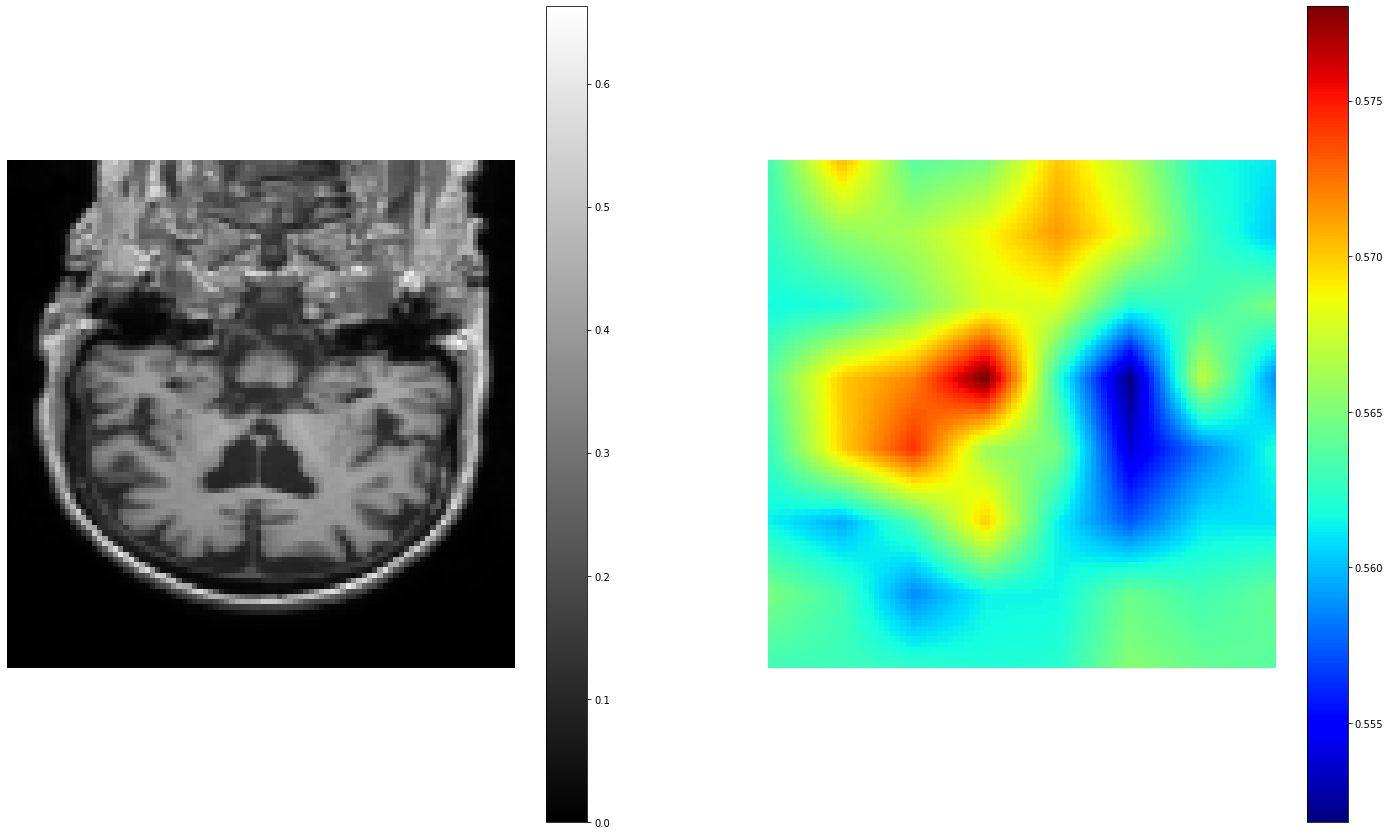

In [10]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [depth_slice-1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

## Cleanup data directory

Remove directory if a temporary was used.